In [19]:
import pandas as pd
import numpy as np
from scipy import stats
from typing import Dict, Any, List, Union
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import joblib
import pandas as pd
import numpy as np
import re

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

#EDA and Feature Engineering

In [20]:
df = pd.read_csv('credit.csv')
print(df.head())
print(df.columns.tolist())
print(df.shape)
print(df['default'].value_counts(dropna=False,normalize=True))
print(df['months_loan_duration'].value_counts(dropna=False, normalize=True).reset_index().head(10))
print(df.isnull().sum()
      )
print(df[df['employment_length'].isna()]['job'].value_counts(dropna=False))
print(df['foreign_worker'].value_counts(dropna=False))
print(df['installment_rate'].unique())
print(df.dtypes)



   Unnamed: 0  checking_balance  months_loan_duration credit_history  \
0           0             -43.0                     6       critical   
1           1              75.0                    48         repaid   
2           2               NaN                    12       critical   
3           3             -32.0                    42         repaid   
4           4             -23.0                    24        delayed   

     purpose  amount  savings_balance employment_length  installment_rate  \
0   radio/tv    1169              NaN          13 years                 4   
1   radio/tv    5951             89.0           2 years                 2   
2  education    2096             24.0           5 years                 2   
3  furniture    7882              9.0           5 years                 2   
4  car (new)    4870             43.0           3 years                 3   

  personal_status other_debtors residence_history                  property  \
0          single        

In [22]:

def univariate_analysis(df: pd.DataFrame) -> pd.DataFrame:
    # quick univariate stats for EDA
    def calc_dist_ranges(series):
        if len(series) == 0: return {f'pct_within_{pct}': np.nan for pct in [66, 95, 98, 99]}
        mean, std = series.mean(), series.std()
        if std == 0: return {f'pct_within_{pct}': 100.0 for pct in [66, 95, 98, 99]}
        ranges = {}
        for pct, mult in {66: 1.0, 95: 2.0, 98: 2.33, 99: 2.58}.items():
            lower, upper = mean - mult * std, mean + mult * std
            ranges[f'pct_within_{pct}'] = ((series >= lower) & (series <= upper)).mean() * 100
        return ranges

    def analyze_var(series, name):
        res = {
            'variable': name,
            'dtype': str(series.dtype),
            'total_count': len(series),
            'missing_count': series.isnull().sum(),
            'missing_pct': (series.isnull().sum() / len(series)) * 100 if len(series) > 0 else 0,
        }
        clean = series.dropna()
        if pd.api.types.is_numeric_dtype(series) and len(clean) > 0:
            for p in [1, 2, 3, 4, 5, 95, 96, 97, 98, 99]:
                res[f'p{p}'] = np.percentile(clean, p)
            res['q1'] = clean.quantile(0.25)
            res['q2'] = clean.quantile(0.5)
            res['q3'] = clean.quantile(0.75)
            res['q4'] = clean.max()
            iqr = res['q3'] - res['q1']
            res['pct_data_in_iqr'] = ((clean >= res['q1']) & (clean <= res['q3'])).mean() * 100
            iqr_lower, iqr_upper = res['q1'] - 1.5 * iqr, res['q3'] + 1.5 * iqr
            res['pct_data_in_oqr'] = ((clean < iqr_lower) | (clean > iqr_upper)).mean() * 100
            res.update(calc_dist_ranges(clean))
            res['skewness'] = stats.skew(clean) if len(clean) > 1 else np.nan
            res['kurtosis'] = stats.kurtosis(clean) if len(clean) > 1 else np.nan
            res['unique_count'] = np.nan
            res['unique_values'] = np.nan
            res['value_percentages'] = np.nan
        else:
            for field in ['p1','p2','p3','p4','p5','p95','p96','p97','p98','p99','q1','q2','q3','q4','pct_data_in_iqr','pct_data_in_oqr','pct_within_66','pct_within_95','pct_within_98','pct_within_99','skewness','kurtosis']:
                res[field] = np.nan
            if len(clean) > 0:
                vc = clean.value_counts()
                res['unique_count'] = clean.nunique()
                res['unique_values'] = vc.index.tolist()
                res['value_percentages'] = (vc / len(clean) * 100).round(2).tolist()
            else:
                res['unique_count'] = 0
                res['unique_values'] = []
                res['value_percentages'] = []
        return res

    results = [analyze_var(df[col], col) for col in df.columns]
    results_df = pd.DataFrame(results)
    num_cols = results_df.select_dtypes(include=[np.number]).columns
    results_df[num_cols] = results_df[num_cols].round(4)
    return results_df

univariate_df=univariate_analysis(df)
univariate_df.to_csv("univariate_analysis_results_model.csv", index=False)

In [35]:
import pandas as pd
import numpy as np
import re

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    df2.columns = df2.columns.astype(str)

    for col in ['checking_balance', 'savings_balance']:
        if col in df2: df2[col] = df2[col].fillna(0)

    if 'personal_status' in df2:
        mode = df2['personal_status'].mode()
        df2['personal_status'] = df2['personal_status'].fillna(mode[0] if len(mode) else 'unknown')

    def time_to_cat(x, typ):
        if pd.isna(x) or str(x).lower() in ['nan', 'none', '']: return 'unemployed' if typ == 'employment' else '< 1 year'
        x = str(x).lower()
        months = 0
        if 'year' in x:
            years = re.findall(r'(\d+)', x)
            months = int(years[0]) * 12 if years else 0
        elif 'month' in x:
            ms = re.findall(r'(\d+)', x)
            months = int(ms[0]) if ms else 0
        if typ == 'employment':
            if months == 0: return 'unemployed'
            elif months < 12: return '< 1 year'
            elif months <= 48: return '1-4 years'
            elif months <= 84: return '4-7 years'
            else: return '> 7 years'
        else:
            if months < 12: return '< 1 year'
            elif months <= 36: return '1-3 years'
            elif months <= 72: return '4-6 years'
            else: return '> 7 years'

    for col in ['employment_length', 'residence_history']:
        if col in df2:
            typ = 'employment' if 'employment' in col else 'residence'
            df2[col] = df2[col].apply(lambda x: time_to_cat(x, typ))

    time_map = {
        'residence_history': {'< 1 year': 6, '1-3 years': 24, '4-6 years': 60, '> 7 years': 96},
        'employment_length': {'unemployed': 0, '< 1 year': 6, '1-4 years': 30, '4-7 years': 66, '> 7 years': 120}
    }
    for col, cmap in time_map.items():
        if col in df2:
            new_col = f"{col}_months"
            df2[new_col] = df2[col].map(cmap).fillna(12)
            df2.drop(col, axis=1, inplace=True)

    if 'telephone' in df2:
        df2['telephone_flag'] = (~df2['telephone'].isna()).astype(int)
        df2.drop('telephone', axis=1, inplace=True)

    if 'purpose' in df2:
        df2['purpose'] = df2['purpose'].astype(str).str.lower()
        others = ['domestic appliances', 'others', 'retraining', 'other']
        df2['purpose_grouped'] = df2['purpose'].where(~df2['purpose'].isin(others), 'others')
        df2.drop('purpose', axis=1, inplace=True)

    for col in df2.columns:
        if df2[col].dtype == 'object' and 'repaid' in col.lower():
            df2[col] = df2[col].astype(str).str.lower()
            df2.loc[df2[col].str.contains('repaid|paid|completed|settled', na=False), col] = 'repaid'

    for col in df2.columns:
        if df2[col].dtype == 'object' and 'property' in col.lower():
            df2[col] = df2[col].astype(str).str.lower()
            df2.loc[df2[col].str.contains('unknown|not known|missing|n/a|nan', na=False), col] = 'other'

    if 'employment_length_months' in df2:
        df2['employment_stable'] = (df2['employment_length_months'] >= 24).astype(int)
        df2['employment_risk'] = (df2['employment_length_months'] < 6).astype(int)
    if 'residence_history_months' in df2:
        df2['residence_stable'] = (df2['residence_history_months'] >= 12).astype(int)
        df2['residence_risk'] = (df2['residence_history_months'] < 6).astype(int)
    if 'employment_length_months' in df2 and 'residence_history_months' in df2:
        df2['stability_score'] = df2['employment_length_months'] * 0.6 + df2['residence_history_months'] * 0.4

    return df2

# Apply the function with error handling
try:
    df_engineered = engineer_features(df)
    df_engineered.to_csv("modeling/engineered_features.csv", index=False)
    print("Feature engineering completed successfully!")
except Exception as e:
    print(f"Error during feature engineering: {str(e)}")
    print(f"Error type: {type(e).__name__}")
    
    # Debug information
    print(f"\nDataFrame info:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Column types: {df.dtypes}")

Feature engineering completed successfully!


#Model Training

In [ ]:
import os
# Create necessary directories
os.makedirs('modeling/intermediate_files/iv', exist_ok=True)
os.makedirs('modeling/intermediate_files/clustering', exist_ok=True)
os.makedirs('modeling', exist_ok=True)


1. Splitting data into train/test (70:30)...
Train set shape: (700, 26)
Test set shape: (300, 26)

2. Calculating Information Value (IV)...
Error calculating IV for residence_risk: 0
Variables by IV
                    Variable        IV
0           checking_balance  0.277940
2             credit_history  0.254391
4            savings_balance  0.248208
1       months_loan_duration  0.219509
25           stability_score  0.152170
20           purpose_grouped  0.130341
18  employment_length_months  0.123361
10          installment_plan  0.116911
11                   housing  0.102040
8                   property  0.091349
3                     amount  0.080223
9                        age  0.077348
14            foreign_worker  0.076739
5           installment_rate  0.033222
16                    gender  0.027539
7              other_debtors  0.026730
15                       job  0.022786
17  residence_history_months  0.011333
6            personal_status  0.006170
12          existing_

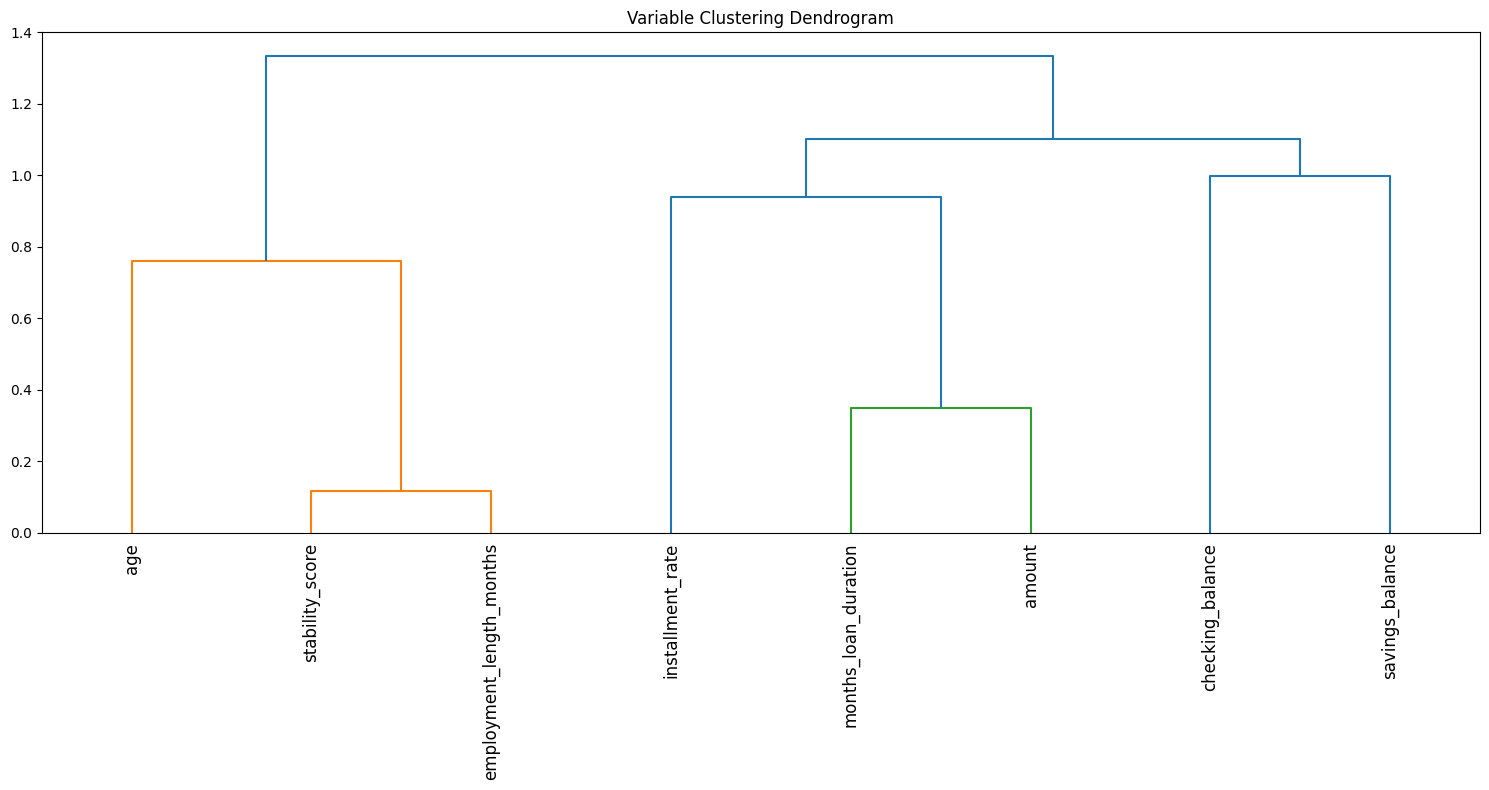

Variables clustered into 7 clusters
Selected 16 variables after clustering

5. Performing WoE binning...
[INFO] creating woe binning ...
WoE binning completed successfully!

6. Applying WoE transformation...
[INFO] converting into woe values ...
[INFO] converting into woe values ...

7. Training Logistic Regression model...

8. Calculating coefficient p-values...
Error calculating p-values: Singular matrix

9. Model Evaluation...

10. Enhanced Bin MAPE Analysis...


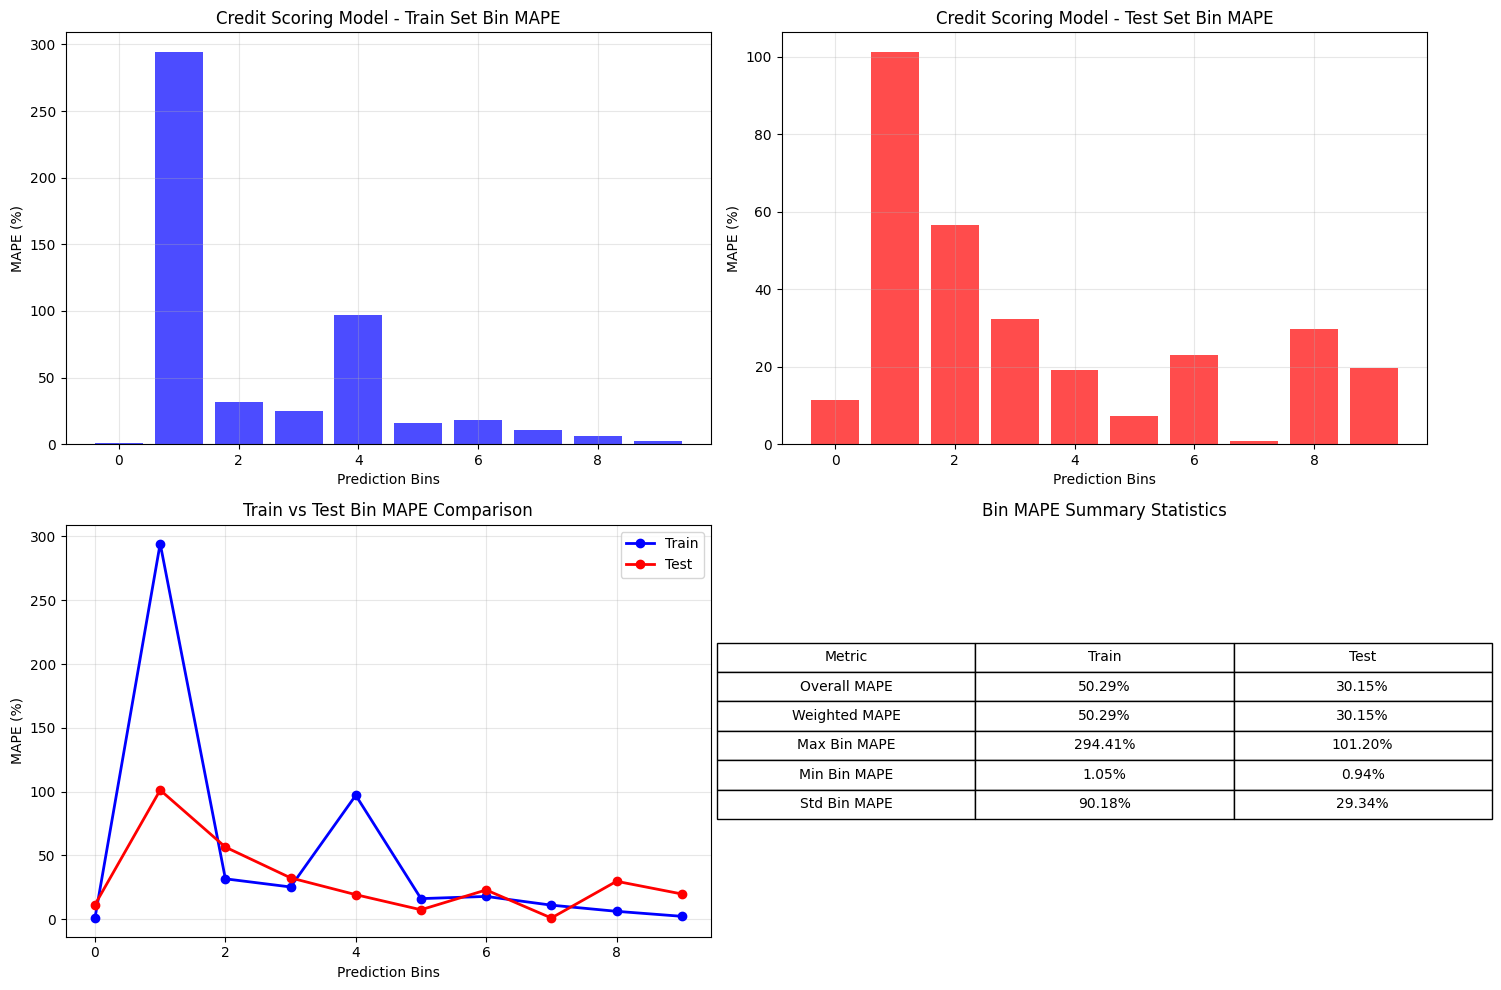


Performance Metrics Summary:
              Metric         Train          Test    Difference
0                AUC  8.341000e-01  7.815000e-01  5.260000e-02
1   Gini Coefficient  6.682000e-01  5.630000e-01  1.052000e-01
2       KS Statistic  5.279000e-01  4.413000e-01  8.660000e-02
3               MAPE  6.743506e+14  7.508599e+14  7.650930e+13
4        Binned MAPE  5.029030e+01  3.015470e+01  2.013560e+01
5  Enhanced Bin MAPE  5.029030e+01  3.015470e+01  2.013560e+01

11. Performing Gains Analysis...

Train Set - Gains Table (Top 10 Deciles):
  decile  total_count  bad_count  bad_rate  cum_bad_pct  lift
9     10           70         54    0.7714       100.00  2.57
8      9           70         46    0.6571        74.29  2.19
7      8           70         30    0.4286        52.38  1.43
6      7           70         30    0.4286        38.10  1.43
5      6           70         22    0.3143        23.81  1.05
4      5           70          7    0.1000        13.33  0.33
3      4          

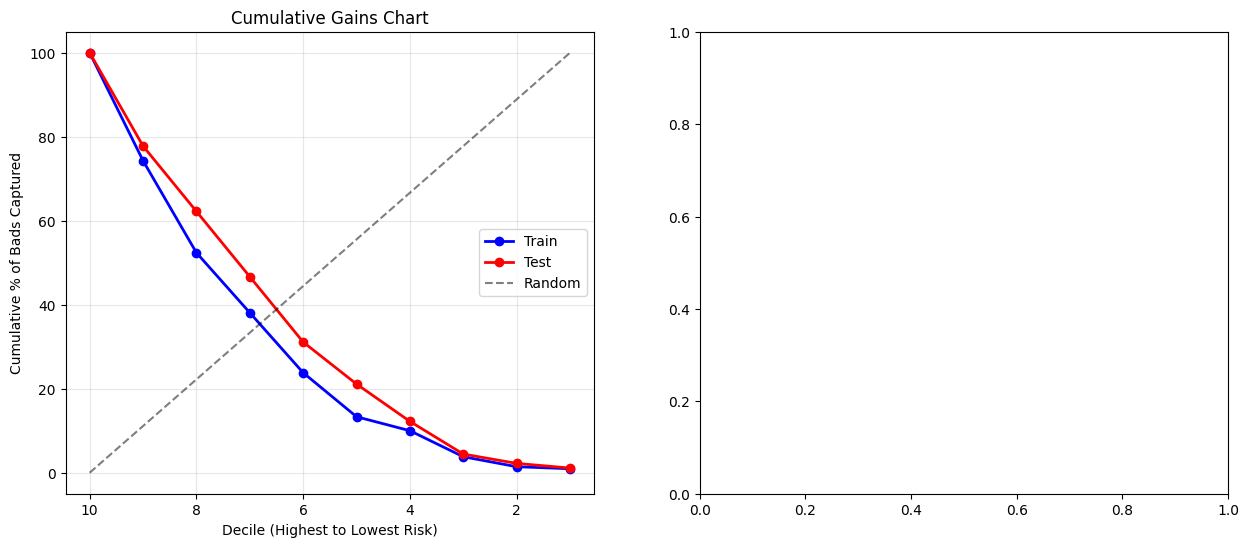

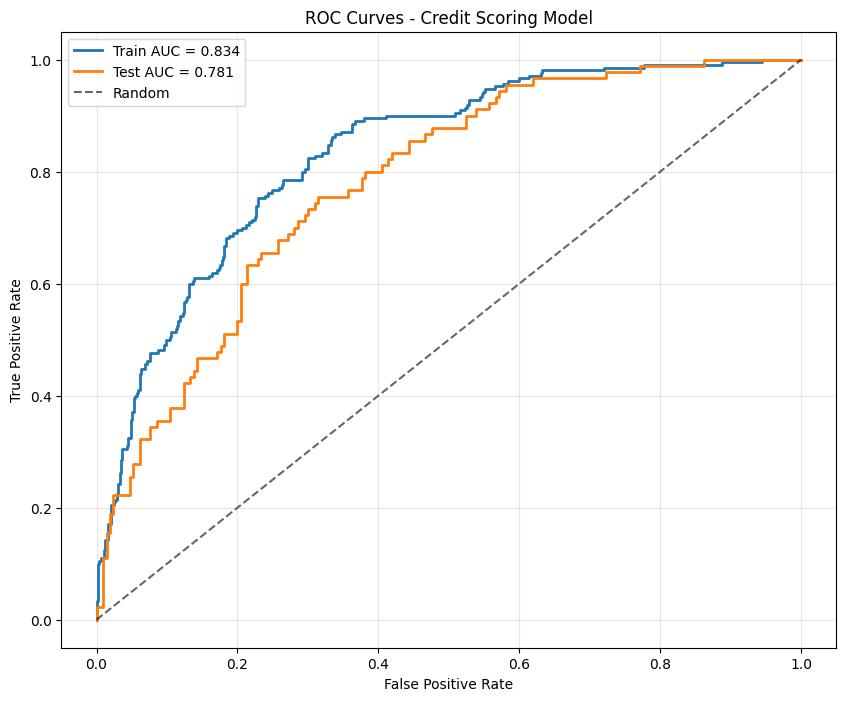

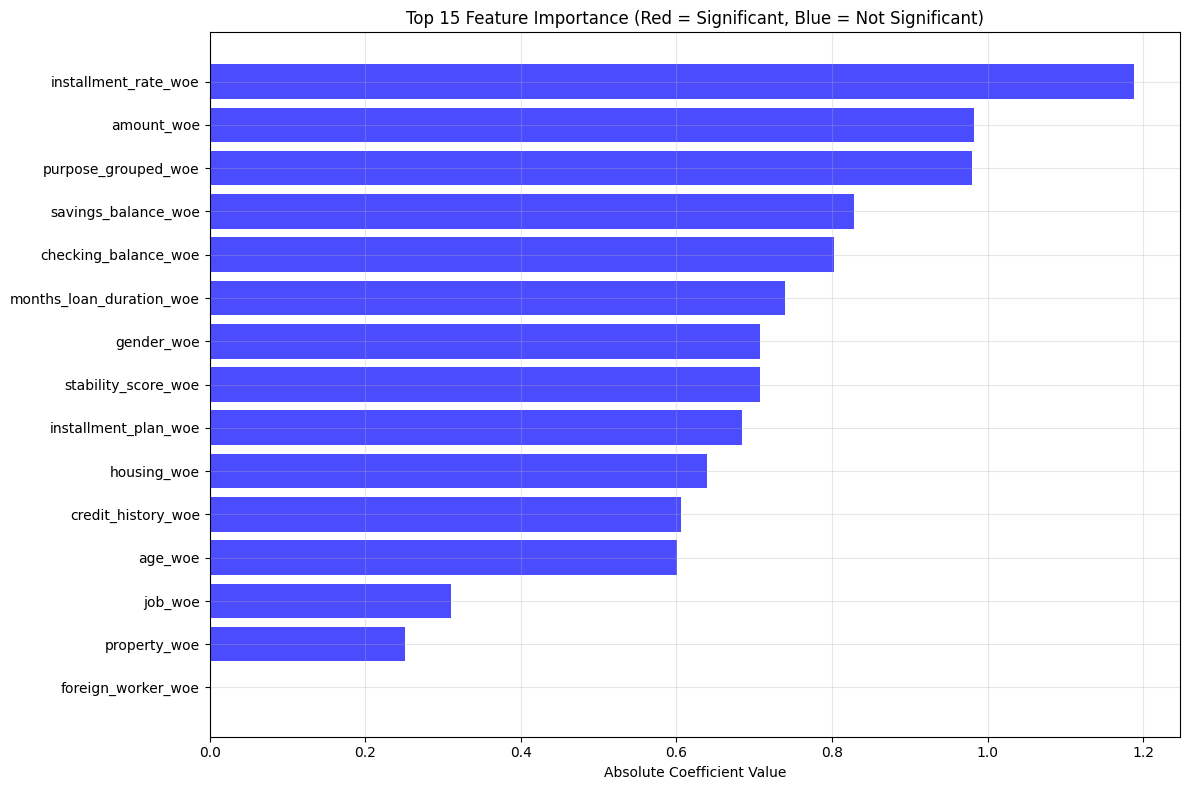

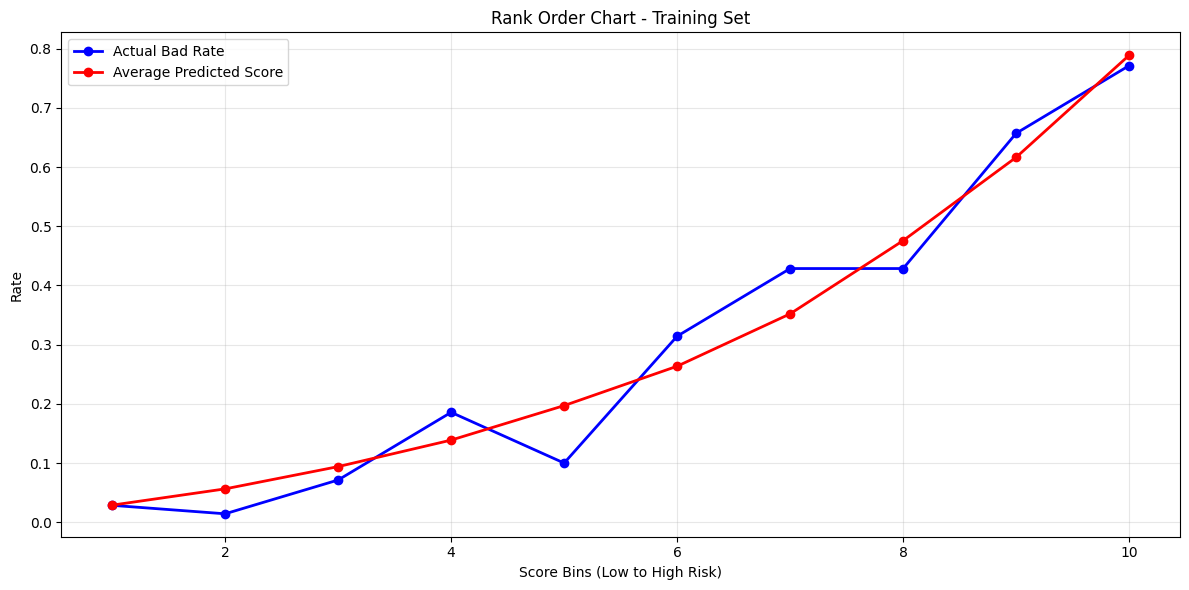

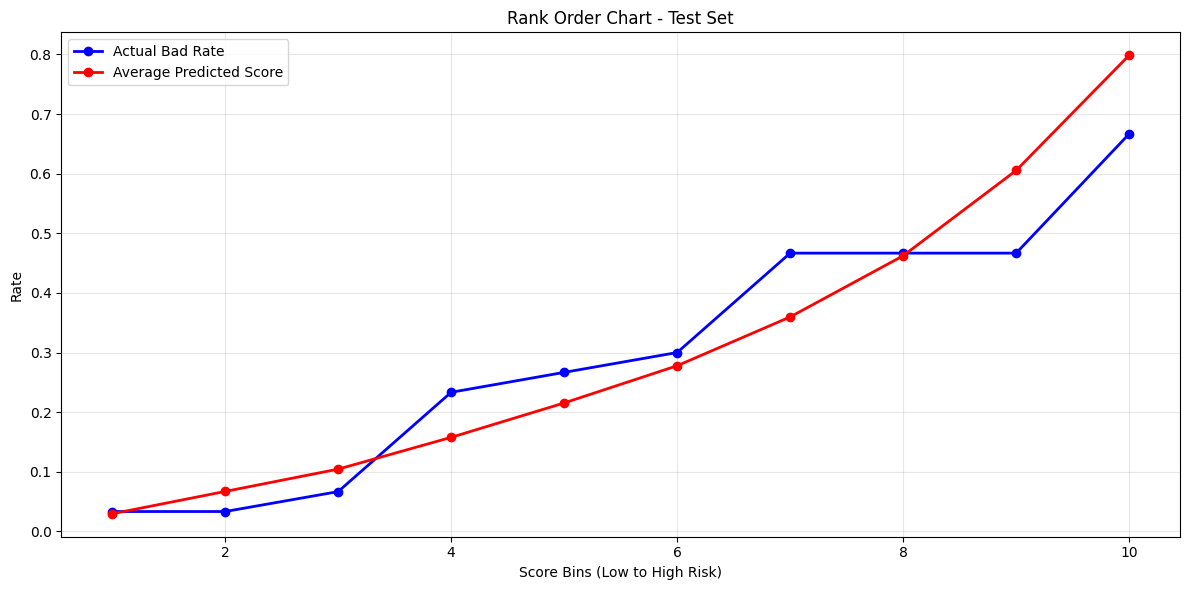


15. Saving results to files...
Error in model setup: name 'significant_vars' is not defined


Traceback (most recent call last):
  File "/var/folders/7w/r4y5t_wn2y901djx6dhyl6xm0000gn/T/ipykernel_39146/1526162940.py", line 972, in <module>
    model_results = train_credit_model(
  File "/var/folders/7w/r4y5t_wn2y901djx6dhyl6xm0000gn/T/ipykernel_39146/1526162940.py", line 916, in train_credit_model
    'significant_variables': len(significant_vars)
NameError: name 'significant_vars' is not defined


In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, mean_absolute_percentage_error
from sklearn.cluster import AgglomerativeClustering
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scorecardpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

def calculate_iv(df, target_col, feature_col):
    """Calculate Information Value for a feature"""
    try:
        if df[feature_col].dtype in ['object', 'category']:
            crosstab = pd.crosstab(df[feature_col], df[target_col])
        else:
            df_temp = df.copy()
            df_temp[f'{feature_col}_binned'] = pd.qcut(df_temp[feature_col], q=10, duplicates='drop')
            crosstab = pd.crosstab(df_temp[f'{feature_col}_binned'], df_temp[target_col])
        
        crosstab['Total'] = crosstab.sum(axis=1)
        crosstab['Good_Rate'] = crosstab[0] / crosstab[0].sum()
        crosstab['Bad_Rate'] = crosstab[1] / crosstab[1].sum()
        
        crosstab['Good_Rate'] = crosstab['Good_Rate'].replace(0, 0.0001)
        crosstab['Bad_Rate'] = crosstab['Bad_Rate'].replace(0, 0.0001)
        
        crosstab['WoE'] = np.log(crosstab['Bad_Rate'] / crosstab['Good_Rate'])
        crosstab['IV'] = (crosstab['Bad_Rate'] - crosstab['Good_Rate']) * crosstab['WoE']
        crosstab.to_csv(f"modeling/intermediate_files/iv/{feature_col}_iv_calculation.csv", index=True)
        return crosstab['IV'].sum()
    except Exception as e:
        print(f"Error calculating IV for {feature_col}: {str(e)}")
        return 0

def calculate_vif(df):
    """Calculate Variance Inflation Factor for all features"""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

def perform_varclus(df, n_clusters=None, correlation_threshold=0.7):
    """Perform variable clustering for feature reduction"""
    corr_matrix = df.corr().abs()
    distance_matrix = 1 - corr_matrix
    
    if n_clusters is None:
        linkage_matrix = linkage(squareform(distance_matrix), method='ward')
        
        plt.figure(figsize=(15, 8))
        dendrogram(linkage_matrix, labels=df.columns, orientation='top')
        plt.title('Variable Clustering Dendrogram')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
        
        clustering = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=1-correlation_threshold,
            linkage='ward'
        )
    else:
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    
    cluster_labels = clustering.fit_predict(distance_matrix)
    
    cluster_df = pd.DataFrame({
        'Variable': df.columns,
        'Cluster': cluster_labels
    })
    
    corr_matrix.to_csv("modeling/intermediate_files/clustering/correlation_matrix.csv", index=True)
    cluster_df.to_csv("modeling/intermediate_files/clustering/cluster_assignments.csv", index=False)
    return cluster_df, corr_matrix

def select_variables_from_clusters(df, target_col, cluster_df, iv_dict, vif_threshold=5.0):
    """Select best variable from each cluster based on highest IV and lowest VIF"""
    selected_variables = []
    cluster_info = []
    
    for cluster_id in cluster_df['Cluster'].unique():
        cluster_vars = cluster_df[cluster_df['Cluster'] == cluster_id]['Variable'].tolist()
        
        if len(cluster_vars) == 1:
            selected_var = cluster_vars[0]
            selected_variables.append(selected_var)
            cluster_info.append({
                'Cluster': cluster_id,
                'Variables_in_Cluster': cluster_vars,
                'Selected_Variable': selected_var,
                'IV': iv_dict.get(selected_var, 0),
                'Selection_Reason': 'Only variable in cluster'
            })
        else:
            cluster_data = df[cluster_vars]
            
            try:
                vif_data = calculate_vif(cluster_data)
                vif_dict = dict(zip(vif_data['Feature'], vif_data['VIF']))
            except:
                vif_dict = {var: 1.0 for var in cluster_vars}
            
            selection_scores = []
            for var in cluster_vars:
                iv_score = iv_dict.get(var, 0)
                vif_score = vif_dict.get(var, float('inf'))
                
                if vif_score > vif_threshold:
                    combined_score = iv_score * 0.5
                else:
                    combined_score = iv_score
                
                selection_scores.append({
                    'Variable': var,
                    'IV': iv_score,
                    'VIF': vif_score,
                    'Combined_Score': combined_score
                })
            
            best_var = max(selection_scores, key=lambda x: x['Combined_Score'])
            selected_variables.append(best_var['Variable'])
            
            cluster_info.append({
                'Cluster': cluster_id,
                'Variables_in_Cluster': cluster_vars,
                'Selected_Variable': best_var['Variable'],
                'IV': best_var['IV'],
                'VIF': best_var['VIF'],
                'Selection_Reason': f"Highest IV ({best_var['IV']:.4f}) with acceptable VIF ({best_var['VIF']:.2f})"
            })
    
    return selected_variables, pd.DataFrame(cluster_info)

def calculate_ks_statistic(y_true, y_pred_proba):
    """Calculate Kolmogorov-Smirnov statistic"""
    good_scores = y_pred_proba[y_true == 0]
    bad_scores = y_pred_proba[y_true == 1]
    ks_stat, p_value = stats.ks_2samp(good_scores, bad_scores)
    return ks_stat, p_value

def calculate_gini_coefficient(y_true, y_pred_proba):
    """Calculate Gini coefficient from AUC"""
    auc = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc - 1
    return gini
import statsmodels.api as sm
def calculate_coefficient_pvalues(X, y, lr_model):
    """Calculate p-values for logistic regression coefficients using statsmodels"""
    try:
        # Add constant for intercept
        X_with_const = sm.add_constant(X)
        
        # Fit statsmodels logistic regression
        logit_model = sm.Logit(y, X_with_const)
        result = logit_model.fit(disp=0)
        
        # Create coefficient summary
        coef_summary = pd.DataFrame({
            'feature': ['intercept'] + list(X.columns),
            'coefficient': result.params.values,
            'std_error': result.bse.values,
            'z_score': result.tvalues.values,
            'p_value': result.pvalues.values,
            'conf_lower': result.conf_int()[0].values,
            'conf_upper': result.conf_int()[1].values
        })
        
        coef_summary['significant'] = coef_summary['p_value'] < 0.05
        
        return coef_summary, result
        
    except Exception as e:
        print(f"Error calculating p-values: {str(e)}")
        # Fallback: create summary without p-values
        coef_summary = pd.DataFrame({
            'feature': ['intercept'] + list(X.columns),
            'coefficient': [lr_model.intercept_[0]] + list(lr_model.coef_[0]),
            'std_error': [np.nan] * (len(X.columns) + 1),
            'z_score': [np.nan] * (len(X.columns) + 1),
            'p_value': [np.nan] * (len(X.columns) + 1),
            'conf_lower': [np.nan] * (len(X.columns) + 1),
            'conf_upper': [np.nan] * (len(X.columns) + 1),
            'significant': [False] * (len(X.columns) + 1)
        })
        
        return coef_summary, None

def calculate_binned_mape(y_true, y_pred_proba, n_bins=10):
    """Calculate MAPE for binned predictions"""
    try:
        df_temp = pd.DataFrame({
            'actual': y_true,
            'predicted': y_pred_proba
        })
        
        df_temp['pred_bin'] = pd.qcut(df_temp['predicted'], q=n_bins, duplicates='drop')
        
        bin_stats = df_temp.groupby('pred_bin').agg({
            'actual': ['mean', 'count'],
            'predicted': 'mean'
        }).round(4)
        
        bin_stats.columns = ['actual_rate', 'count', 'pred_rate']
        bin_stats['mape'] = np.abs((bin_stats['actual_rate'] - bin_stats['pred_rate']) / 
                                  np.maximum(bin_stats['actual_rate'], 0.001)) * 100
        
        overall_mape = bin_stats['mape'].mean()
        
        return overall_mape, bin_stats
        
    except Exception as e:
        print(f"Error calculating binned MAPE: {str(e)}")
        return 0, pd.DataFrame()

def calculate_enhanced_bin_mape(y_true, y_pred_proba, n_bins=10):
    """Calculate enhanced bin MAPE with additional statistics"""
    try:
        df_temp = pd.DataFrame({
            'actual': y_true,
            'predicted': y_pred_proba
        })
        
        df_temp['pred_bin'] = pd.qcut(df_temp['predicted'], q=n_bins, duplicates='drop')
        
        bin_stats = df_temp.groupby('pred_bin').agg({
            'actual': ['mean', 'count', 'sum'],
            'predicted': ['mean', 'std']
        }).round(4)
        
        bin_stats.columns = ['actual_rate', 'count', 'actual_count', 'pred_rate', 'pred_std']
        bin_stats['mape'] = np.abs((bin_stats['actual_rate'] - bin_stats['pred_rate']) / 
                                  np.maximum(bin_stats['actual_rate'], 0.001)) * 100
        
        bin_stats['weight'] = bin_stats['count'] / bin_stats['count'].sum()
        
        overall_mape = bin_stats['mape'].mean()
        weighted_mape = (bin_stats['mape'] * bin_stats['weight']).sum()
        
        return {
            'overall_mape': overall_mape,
            'weighted_mape': weighted_mape,
            'bin_details': bin_stats,
            'max_bin_mape': bin_stats['mape'].max(),
            'min_bin_mape': bin_stats['mape'].min(),
            'std_bin_mape': bin_stats['mape'].std()
        }
        
    except Exception as e:
        print(f"Error calculating enhanced bin MAPE: {str(e)}")
        return {
            'overall_mape': 0,
            'weighted_mape': 0,
            'bin_details': pd.DataFrame(),
            'max_bin_mape': 0,
            'min_bin_mape': 0,
            'std_bin_mape': 0
        }

def plot_bin_mape_analysis(train_stats, test_stats, title="Model"):
    """Plot bin MAPE analysis and return comparison table"""
    try:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Train bin MAPE
        train_bins = train_stats['bin_details']
        ax1.bar(range(len(train_bins)), train_bins['mape'], alpha=0.7, color='blue')
        ax1.set_title(f'{title} - Train Set Bin MAPE')
        ax1.set_xlabel('Prediction Bins')
        ax1.set_ylabel('MAPE (%)')
        ax1.grid(True, alpha=0.3)
        
        # Test bin MAPE
        test_bins = test_stats['bin_details']
        ax2.bar(range(len(test_bins)), test_bins['mape'], alpha=0.7, color='red')
        ax2.set_title(f'{title} - Test Set Bin MAPE')
        ax2.set_xlabel('Prediction Bins')
        ax2.set_ylabel('MAPE (%)')
        ax2.grid(True, alpha=0.3)
        
        # Comparison
        comparison_data = pd.DataFrame({
            'Bin': range(min(len(train_bins), len(test_bins))),
            'Train_MAPE': train_bins['mape'].values[:min(len(train_bins), len(test_bins))],
            'Test_MAPE': test_bins['mape'].values[:min(len(train_bins), len(test_bins))]
        })
        
        ax3.plot(comparison_data['Bin'], comparison_data['Train_MAPE'], 'b-o', label='Train', linewidth=2)
        ax3.plot(comparison_data['Bin'], comparison_data['Test_MAPE'], 'r-o', label='Test', linewidth=2)
        ax3.set_title('Train vs Test Bin MAPE Comparison')
        ax3.set_xlabel('Prediction Bins')
        ax3.set_ylabel('MAPE (%)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Summary statistics
        summary_stats = [
            ['Overall MAPE', f"{train_stats['overall_mape']:.2f}%", f"{test_stats['overall_mape']:.2f}%"],
            ['Weighted MAPE', f"{train_stats['weighted_mape']:.2f}%", f"{test_stats['weighted_mape']:.2f}%"],
            ['Max Bin MAPE', f"{train_stats['max_bin_mape']:.2f}%", f"{test_stats['max_bin_mape']:.2f}%"],
            ['Min Bin MAPE', f"{train_stats['min_bin_mape']:.2f}%", f"{test_stats['min_bin_mape']:.2f}%"],
            ['Std Bin MAPE', f"{train_stats['std_bin_mape']:.2f}%", f"{test_stats['std_bin_mape']:.2f}%"]
        ]
        
        ax4.axis('tight')
        ax4.axis('off')
        table = ax4.table(cellText=summary_stats,
                         colLabels=['Metric', 'Train', 'Test'],
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        ax4.set_title('Bin MAPE Summary Statistics')
        
        plt.tight_layout()
        plt.show()
        
        return pd.DataFrame(summary_stats, columns=['Metric', 'Train', 'Test'])
        
    except Exception as e:
        print(f"Error plotting bin MAPE analysis: {str(e)}")
        return pd.DataFrame()

def calculate_gains_table(y_true, y_pred_proba, n_deciles=10):
    """Calculate gains table for model evaluation"""
    try:
        df_gains = pd.DataFrame({
            'actual': y_true,
            'predicted_proba': y_pred_proba
        })
        
        df_gains['decile'] = pd.qcut(df_gains['predicted_proba'], q=n_deciles, 
                                   labels=range(1, n_deciles+1), duplicates='drop')
        df_gains = df_gains.sort_values('decile')
        
        gains_table = df_gains.groupby('decile').agg({
            'actual': ['count', 'sum', 'mean'],
            'predicted_proba': ['mean', 'min', 'max']
        }).round(4)
        
        gains_table.columns = ['total_count', 'bad_count', 'bad_rate', 
                              'avg_pred_proba', 'min_pred_proba', 'max_pred_proba']
        
        gains_table['cum_bad_count'] = gains_table['bad_count'].cumsum()
        gains_table['cum_bad_pct'] = (gains_table['cum_bad_count'] / 
                                     gains_table['bad_count'].sum() * 100).round(2)
        
        overall_bad_rate = y_true.mean()
        gains_table['lift'] = (gains_table['bad_rate'] / overall_bad_rate).round(2)
        
        gains_table = gains_table.reset_index()
        gains_table = gains_table.sort_values('decile', ascending=False)
        
        return gains_table
        
    except Exception as e:
        print(f"Error calculating gains table: {str(e)}")
        return pd.DataFrame()

def plot_gains_chart(train_gains, test_gains):
    """Plot gains chart for train and test sets"""
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Cumulative gains chart
        ax1.plot(train_gains['decile'], train_gains['cum_bad_pct'], 'b-o', 
                label='Train', linewidth=2, markersize=6)
        ax1.plot(test_gains['decile'], test_gains['cum_bad_pct'], 'r-o', 
                label='Test', linewidth=2, markersize=6)
        ax1.plot([10, 1], [0, 100], 'k--', alpha=0.5, label='Random')
        ax1.set_xlabel('Decile (Highest to Lowest Risk)')
        ax1.set_ylabel('Cumulative % of Bads Captured')
        ax1.set_title('Cumulative Gains Chart')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.invert_xaxis()
        
        # Lift chart
        ax2.bar(train_gains['decile'] - 0.2, train_gains['lift'], 
               width=0.4, alpha=0.7, label='Train', color='blue')
        ax2.bar(test_gains['decile'] + 0.2, test_gains['lift'], 
               width=0.4, alpha=0.7, label='Test', color='red')
        ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Baseline')
        ax2.set_xlabel('Decile (Highest to Lowest Risk)')
        ax2.set_ylabel('Lift')
        ax2.set_title('Lift Chart')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.invert_xaxis()
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error plotting gains chart: {str(e)}")

def create_rank_order_chart(y_true, y_pred_proba, dataset_name="Dataset"):
    """Create rank order chart and return statistics"""
    try:
        df_rank = pd.DataFrame({
            'actual': y_true,
            'predicted_proba': y_pred_proba
        })
        
        df_rank['score_bin'] = pd.qcut(df_rank['predicted_proba'], q=10, duplicates='drop')
        
        rank_stats = df_rank.groupby('score_bin').agg({
            'actual': ['count', 'sum', 'mean'],
            'predicted_proba': 'mean'
        }).round(4)
        
        rank_stats.columns = ['count', 'bads', 'bad_rate', 'avg_score']
        rank_stats = rank_stats.reset_index()
        rank_stats['bin_number'] = range(1, len(rank_stats) + 1)
        
        plt.figure(figsize=(12, 6))
        plt.plot(rank_stats['bin_number'], rank_stats['bad_rate'], 'b-o', 
                linewidth=2, markersize=6, label='Actual Bad Rate')
        plt.plot(rank_stats['bin_number'], rank_stats['avg_score'], 'r-o', 
                linewidth=2, markersize=6, label='Average Predicted Score')
        plt.xlabel('Score Bins (Low to High Risk)')
        plt.ylabel('Rate')
        plt.title(f'Rank Order Chart - {dataset_name}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return rank_stats
        
    except Exception as e:
        print(f"Error creating rank order chart: {str(e)}")
        return pd.DataFrame()
def is_monotonic(woe_list):
    return (all(x <= y for x, y in zip(woe_list, woe_list[1:])) or
            all(x >= y for x, y in zip(woe_list, woe_list[1:])))

def check_and_enforce_monotonicity(bins, train_data_final, target_column):
    """Check and enforce monotonicity for all variables in bins"""
    print("\n5.1. Checking monotonicity of WoE values...")
    
    non_monotonic_vars = []
    
    # Check monotonicity for each variable
    for var in bins:
        woe_values = bins[var]['woe'].values
        if not is_monotonic(woe_values):
            print(f"  {var} is NOT monotonic")
            non_monotonic_vars.append(var)
        else:
            print(f"  {var} is monotonic ✓")
    
    if non_monotonic_vars:
        print(f"\n5.2. Re-binning {len(non_monotonic_vars)} non-monotonic variables...")
        
        for var in non_monotonic_vars:
            print(f"  Re-binning {var}...")
            
            # Try different methods to achieve monotonicity
            methods_to_try = ['chimerge', 'tree']
            bin_nums_to_try = [3, 4, 5]
            
            monotonic_achieved = False
            
            for method in methods_to_try:
                if monotonic_achieved:
                    break
                    
                for bin_num in bin_nums_to_try:
                    try:
                        new_bins = sc.woebin(
                            train_data_final[[var, target_column]],
                            y=target_column,
                            x=[var],
                            positive="1",
                            method=method,
                            bin_num=bin_num,
                            print_step=0
                        )
                        
                        new_woe_values = new_bins[var]['woe'].values
                        
                        if is_monotonic(new_woe_values):
                            bins[var] = new_bins[var]
                            print(f"    ✓ Achieved monotonicity with method='{method}', bin_num={bin_num}")
                            monotonic_achieved = True
                            break
                            
                    except Exception as e:
                        continue
            
            if not monotonic_achieved:
                print(f"    ⚠ Could not achieve monotonicity for {var}, keeping original bins")
    
    else:
        print("  All variables are already monotonic ✓")
    
    return bins


def train_credit_model(df_engineered, target_column='default', iv_threshold=0.02, 
                      correlation_threshold=0.7, vif_threshold=5.0, n_bins_mape=10):
    """
    pipeline for credit scoring model training with variable selection, WoE binning, 
     evaluation 
    """
    
    if target_column not in df_engineered.columns:
        raise ValueError(f"Target column '{target_column}' not found in DataFrame")
    
    
    print("="*80)
    
    # 1. Train-Test Split
    print("1. Splitting data into train/test (70:30)...")
    
    # Remove unnamed columns if they exist
    cols_to_drop = [col for col in df_engineered.columns if 'Unnamed: 0' in str(col)]
    if cols_to_drop:
        df_engineered = df_engineered.drop(columns=cols_to_drop)
    
    X = df_engineered.drop(columns=[target_column])
    y = df_engineered[target_column]
    
    if y.dtype == 'object':
        unique_vals = y.unique()
        if len(unique_vals) == 2:
            y = (y == unique_vals[1]).astype(int)
        else:
            raise ValueError(f"Target column has {len(unique_vals)} unique values, expected 2")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"Train set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    train_data = X_train.copy()
    train_data[target_column] = y_train
    
    # 2. Calculate Information Value
    print(f"\n2. Calculating Information Value (IV)...")
    
    iv_dict = {}
    for col in X_train.columns:
        try:
            iv_value = calculate_iv(train_data, target_column, col)
            iv_dict[col] = iv_value
        except Exception as e:
            print(f"Warning: Could not calculate IV for {col}: {str(e)}")
            iv_dict[col] = 0
    
    iv_df = pd.DataFrame(list(iv_dict.items()), columns=['Variable', 'IV'])
    iv_df = iv_df.sort_values('IV', ascending=False)
    
    print(f"Variables by IV")
    print(iv_df)
    
    # 3. Filter variables by IV threshold
    print(f"\n3. Filtering variables with IV > {iv_threshold}...")
    
    high_iv_vars = iv_df[iv_df['IV'] > iv_threshold]['Variable'].tolist()
    print(f"Variables with IV > {iv_threshold}: {len(high_iv_vars)} out of {len(iv_df)}")
    
    if len(high_iv_vars) == 0:
        raise ValueError(f"No variables found with IV > {iv_threshold}. Consider lowering the threshold.")
    
    X_train_filtered = X_train[high_iv_vars]
    X_test_filtered = X_test[high_iv_vars]
    
    # 4. Variable Clustering
    print(f"\n4. Performing Variable Clustering (VarClus)...")
    
    numeric_vars = X_train_filtered.select_dtypes(include=[np.number]).columns.tolist()
    
    if len(numeric_vars) < 2:
        print("Warning: Less than 2 numeric variables. Skipping VarClus.")
        selected_variables = high_iv_vars
        cluster_info_df = pd.DataFrame()
    else:
        cluster_df, corr_matrix = perform_varclus(
            X_train_filtered[numeric_vars], 
            correlation_threshold=correlation_threshold
        )
        
        print(f"Variables clustered into {cluster_df['Cluster'].nunique()} clusters")
        
        selected_variables, cluster_info_df = select_variables_from_clusters(
            X_train_filtered[numeric_vars], 
            target_column, 
            cluster_df, 
            iv_dict, 
            vif_threshold=vif_threshold
        )
        
        categorical_vars = [var for var in high_iv_vars if var not in numeric_vars]
        selected_variables.extend(categorical_vars)
        
        print(f"Selected {len(selected_variables)} variables after clustering")
    
    X_train_final = X_train[selected_variables]
    X_test_final = X_test[selected_variables]
    
    # # 5. WoE Binning
    print(f"\n5. Performing WoE binning...")
    
    train_data_final = X_train_final.copy()
    train_data_final[target_column] = y_train
    
    try:
        bins = sc.woebin(
            train_data_final, 
            y=target_column,
            x=selected_variables,
            positive="1",
            no_cores=1,
            print_step=0,
            replace_blank=True
        )
        print("WoE binning completed successfully!")
        
    except Exception as e:
        print(f"Error in WoE binning: {str(e)}")
        numeric_selected = [var for var in selected_variables if var in X_train_final.select_dtypes(include=[np.number]).columns]
        bins = sc.woebin(
            train_data_final[numeric_selected + [target_column]], 
            y=target_column,
            positive="1",
            no_cores=1,
            print_step=0
        )
    
    # 6. WoE Transformation
    print(f"\n6. Applying WoE transformation...")
    
    train_woe = sc.woebin_ply(train_data_final, bins, no_cores=1, print_step=0)
    
    test_data_final = X_test_final.copy()
    test_data_final[target_column] = y_test
    test_woe = sc.woebin_ply(test_data_final, bins, no_cores=1, print_step=0)
    
    X_train_woe = train_woe.drop(columns=[target_column])
    y_train_woe = train_woe[target_column]
    X_test_woe = test_woe.drop(columns=[target_column])
    y_test_woe = test_woe[target_column]
    
#     # 5. WoE Binning
#     print(f"\n5. Performing WoE binning...")

#     train_data_final = X_train_final.copy()
#     train_data_final[target_column] = y_train

#     try:
#         bins = sc.woebin(
#             train_data_final, 
#             y=target_column,
#             x=selected_variables,
#             positive="1",
#             no_cores=1,
#             print_step=0,
#             replace_blank=True
#         )
#         print("WoE binning completed successfully!")
        
#     except Exception as e:
#         print(f"Error in WoE binning: {str(e)}")
#         numeric_selected = [var for var in selected_variables if var in X_train_final.select_dtypes(include=[np.number]).columns]
#         bins = sc.woebin(
#             train_data_final[numeric_selected + [target_column]], 
#             y=target_column,
#             positive="1",
#             no_cores=1,
#             print_step=0
#         )

# # 5.1. Check and enforce monotonicity

#     # Apply monotonicity check and enforcement
#     bins = check_and_enforce_monotonicity(bins, train_data_final, target_column)

#     # 6. WoE Transformation
#     print(f"\n6. Applying WoE transformation...")

#     train_woe = sc.woebin_ply(train_data_final, bins, no_cores=1, print_step=0)

#     test_data_final = X_test_final.copy()
#     test_data_final[target_column] = y_test
#     test_woe = sc.woebin_ply(test_data_final, bins, no_cores=1, print_step=0)

#     X_train_woe = train_woe.drop(columns=[target_column])
#     y_train_woe = train_woe[target_column]
#     X_test_woe = test_woe.drop(columns=[target_column])
#     y_test_woe = test_woe[target_column]

#     # 6.1. Final monotonicity verification
#     print(f"\n6.1. Final monotonicity verification...")
#     for var in bins:
#         woe_values = bins[var]['woe'].values
#         if not is_monotonic(woe_values):
#             print(f"  ⚠ {var} is still NOT monotonic")
#         else:
#             print(f"  ✓ {var} is monotonic")
    
    # 7. Train Logistic Regression
    print(f"\n7. Training Logistic Regression model...")
    
    lr_model = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
    lr_model.fit(X_train_woe, y_train_woe)
    
    # Ensure directory exists before saving
    os.makedirs("modeling", exist_ok=True)
    joblib.dump(lr_model, 'modeling/model.pkl')
    
    # 8. Calculate Coefficient P-values
    print(f"\n8. Calculating coefficient p-values...")
    
    coef_summary, statsmodel_result = calculate_coefficient_pvalues(X_train_woe, y_train_woe, lr_model)
    
    # print("\nCoefficient Summary with P-values:")
    # print("="*70)
    # print(f"{'Feature':<25} {'Coefficient':<12} {'P-value':<12} {'Significant':<12}")
    # print("-" * 70)
    # for _, row in coef_summary.iterrows():
    #     sig_marker = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    #     print(f"{row['feature']:<25} {row['coefficient']:<12.6f} {row['p_value']:<12.6f} {str(row['significant']) + sig_marker:<12}")
    
    # significant_vars = coef_summary[coef_summary['significant'] == True]['feature'].tolist()
    # print(f"\nSignificant variables (p < 0.05): {len(significant_vars)} out of {len(coef_summary)}")
    # if significant_vars:
    #     print("Significant variables:", significant_vars)
    
    # 9. Model Evaluation
    print(f"\n9. Model Evaluation...")
    
    y_train_pred = lr_model.predict(X_train_woe)
    y_test_pred = lr_model.predict(X_test_woe)
    
    y_train_pred_proba = lr_model.predict_proba(X_train_woe)[:, 1]
    y_test_pred_proba = lr_model.predict_proba(X_test_woe)[:, 1]
    
    # Calculate metrics
    train_auc = roc_auc_score(y_train_woe, y_train_pred_proba)
    test_auc = roc_auc_score(y_test_woe, y_test_pred_proba)
    
    train_gini = calculate_gini_coefficient(y_train_woe, y_train_pred_proba)
    test_gini = calculate_gini_coefficient(y_test_woe, y_test_pred_proba)
    
    train_ks, train_ks_pvalue = calculate_ks_statistic(y_train_woe, y_train_pred_proba)
    test_ks, test_ks_pvalue = calculate_ks_statistic(y_test_woe, y_test_pred_proba)
    
    train_mape = mean_absolute_percentage_error(y_train_woe, y_train_pred_proba)
    test_mape = mean_absolute_percentage_error(y_test_woe, y_test_pred_proba)
    
    train_binned_mape, train_bin_details = calculate_binned_mape(y_train_woe, y_train_pred_proba)
    test_binned_mape, test_bin_details = calculate_binned_mape(y_test_woe, y_test_pred_proba)
    
    # 10. Enhanced Bin MAPE Analysis
    print(f"\n10. Enhanced Bin MAPE Analysis...")
    
    train_bin_stats = calculate_enhanced_bin_mape(y_train_woe, y_train_pred_proba, n_bins_mape)
    test_bin_stats = calculate_enhanced_bin_mape(y_test_woe, y_test_pred_proba, n_bins_mape)
    
    # Plot bin MAPE analysis
    bin_mape_table = plot_bin_mape_analysis(train_bin_stats, test_bin_stats, "Credit Scoring Model")
    
    # Save bin MAPE results to CSV
    os.makedirs("modeling/intermediate_files", exist_ok=True)
    bin_mape_table.to_csv("modeling/intermediate_files/bin_mape_analysis.csv", index=False)
    
    metrics_df = pd.DataFrame({
        'Metric': ['AUC', 'Gini Coefficient', 'KS Statistic', 'MAPE', 'Binned MAPE', 'Enhanced Bin MAPE'],
        'Train': [train_auc, train_gini, train_ks, train_mape, train_binned_mape, train_bin_stats['overall_mape']],
        'Test': [test_auc, test_gini, test_ks, test_mape, test_binned_mape, test_bin_stats['overall_mape']],
        'Difference': [
            abs(train_auc - test_auc),
            abs(train_gini - test_gini),
            abs(train_ks - test_ks),
            abs(train_mape - test_mape),
            abs(train_binned_mape - test_binned_mape),
            abs(train_bin_stats['overall_mape'] - test_bin_stats['overall_mape'])
        ]
    })
    
    print("\nPerformance Metrics Summary:")
    print(metrics_df.round(4))
    
    # 11. Gains Analysis
    print(f"\n11. Performing Gains Analysis...")
    
    train_gains = calculate_gains_table(y_train_woe, y_train_pred_proba)
    test_gains = calculate_gains_table(y_test_woe, y_test_pred_proba)
    
    print("\nTrain Set - Gains Table (Top 10 Deciles):")
    print(train_gains[['decile', 'total_count', 'bad_count', 'bad_rate', 'cum_bad_pct', 'lift']].head(10))
    
    print("\nTest Set - Gains Table (Top 10 Deciles):")
    print(test_gains[['decile', 'total_count', 'bad_count', 'bad_rate', 'cum_bad_pct', 'lift']].head(10))
    
    train_top_decile_capture = train_gains.iloc[0]['bad_count'] / train_gains['bad_count'].sum() * 100
    test_top_decile_capture = test_gains.iloc[0]['bad_count'] / test_gains['bad_count'].sum() * 100
    
    train_top3_capture = train_gains.iloc[:3]['bad_count'].sum() / train_gains['bad_count'].sum() * 100
    test_top3_capture = test_gains.iloc[:3]['bad_count'].sum() / test_gains['bad_count'].sum() * 100
    
    print(f"\nGains Summary:")
    print(f"Top Decile Bad Capture - Train: {train_top_decile_capture:.1f}%, Test: {test_top_decile_capture:.1f}%")
    print(f"Top 3 Deciles Bad Capture - Train: {train_top3_capture:.1f}%, Test: {test_top3_capture:.1f}%")
    
    plot_gains_chart(train_gains, test_gains)
    
    # 12. Feature importance with p-values
    feature_importance = pd.DataFrame({
        'feature': X_train_woe.columns,
        'coefficient': lr_model.coef_[0],
        'abs_coefficient': np.abs(lr_model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    # Merge with p-values
    feature_importance = feature_importance.merge(
        coef_summary[coef_summary['feature'] != 'intercept'][['feature', 'p_value', 'significant']], 
        on='feature', 
        how='left'
    )
    
    print("\nTop 10 Most Important Features with P-values:")
    print("="*80)
    print(f"{'Feature':<25} {'Coefficient':<12} {'Abs Coef':<12} {'P-value':<12} {'Significant':<12}")
    print("-" * 80)
    for _, row in feature_importance.head(10).iterrows():
        sig_marker = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
        print(f"{row['feature']:<25} {row['coefficient']:<12.6f} {row['abs_coefficient']:<12.6f} "
              f"{row['p_value']:<12.6f} {str(row['significant']) + sig_marker:<12}")
    
    # 13. Visualizations
    print(f"\n13. Creating visualizations...")
    
    # ROC Curve
    fpr_train, tpr_train, _ = roc_curve(y_train_woe, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test_woe, y_test_pred_proba)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr_train, tpr_train, label=f'Train AUC = {train_auc:.3f}', linewidth=2)
    plt.plot(fpr_test, tpr_test, label=f'Test AUC = {test_auc:.3f}', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.6)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Credit Scoring Model')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Feature Importance Plot
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    colors = ['red' if sig else 'blue' for sig in top_features['significant']]
    
    plt.barh(range(len(top_features)), top_features['abs_coefficient'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Top 15 Feature Importance (Red = Significant, Blue = Not Significant)')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 14. Rank Order Charts
    train_rank_stats = create_rank_order_chart(y_train_woe, y_train_pred_proba, "Training Set")
    test_rank_stats = create_rank_order_chart(y_test_woe, y_test_pred_proba, "Test Set")
    
    # 15. Save all results to files
    print(f"\n15. Saving results to files...")
    
    # Save coefficient summary
    coef_summary.to_csv("modeling/intermediate_files/coefficient_summary.csv", index=False)
    
    # Save feature importance
    feature_importance.to_csv("modeling/intermediate_files/feature_importance.csv", index=False)
    
    # Save metrics summary
    metrics_df.to_csv("modeling/intermediate_files/metrics_summary.csv", index=False)
    
    # Save gains tables
    train_gains.to_csv("modeling/intermediate_files/train_gains.csv", index=False)
    test_gains.to_csv("modeling/intermediate_files/test_gains.csv", index=False)
    
    # Save IV results
    iv_df.to_csv("modeling/intermediate_files/iv_results.csv", index=False)
    
    # Return comprehensive results
    results = {
        'model': lr_model,
        'bins': bins,
        'X_train_woe': X_train_woe,
        'X_test_woe': X_test_woe,
        'y_train': y_train_woe,
        'y_test': y_test_woe,
        'train_predictions': y_train_pred_proba,
        'test_predictions': y_test_pred_proba,
        'iv_df': iv_df,
        'selected_variables': selected_variables,
        'cluster_info': cluster_info_df,
        'coefficient_summary': coef_summary,
        'statsmodel_result': statsmodel_result,
        'feature_importance': feature_importance,
        'variable_selection_summary': {
            'original_count': X.shape[1],
            'after_iv_filter': len(high_iv_vars),
            'after_varclus': len(selected_variables),
            'final_model': X_train_woe.shape[1],
            'significant_variables': len(significant_vars)
        },
        'metrics_summary': metrics_df,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'train_gini': train_gini,
        'test_gini': test_gini,
        'train_ks': train_ks,
        'test_ks': test_ks,
        'train_gains': train_gains,
        'test_gains': test_gains,
        'gains_summary': {
            'train_top_decile_capture': train_top_decile_capture,
            'test_top_decile_capture': test_top_decile_capture,
            'train_top3_capture': train_top3_capture,
            'test_top3_capture': test_top3_capture
        },
        'train_rank_stats': train_rank_stats,
        'test_rank_stats': test_rank_stats,
        'train_bin_stats': train_bin_stats,
        'test_bin_stats': test_bin_stats,
        'bin_mape_table': bin_mape_table
    }
    
    print("\nModel training pipeline completed!")
    print("\nFinal Summary:")
    print("="*70)
    print(f"Variable Selection:")
    print(f"  Original variables: {X.shape[1]}")
    print(f"  After IV > {iv_threshold}: {len(high_iv_vars)}")
    print(f"  After VarClus: {len(selected_variables)}")
    print(f"  Final model: {X_train_woe.shape[1]}")
    print(f"  Significant variables (p<0.05): {len(significant_vars)}")
    print(f"\nModel Performance:")
    print(f"  Test AUC: {test_auc:.4f}")
    print(f"  Test Gini: {test_gini:.4f}")
    print(f"  Test KS: {test_ks:.4f}")
    print(f"  Test Enhanced Bin MAPE: {test_bin_stats['overall_mape']:.2f}%")
    print(f"  Test Weighted Bin MAPE: {test_bin_stats['weighted_mape']:.2f}%")
    print(f"\nGains Analysis:")
    print(f"  Top Decile Capture: {test_top_decile_capture:.1f}%")
    print(f"  Top 3 Deciles Capture: {test_top3_capture:.1f}%")
    print(f"\nModel Stability:")
    print(f"  AUC Difference (Train-Test): {abs(train_auc - test_auc):.4f}")
    print(f"  Bin MAPE Difference: {abs(train_bin_stats['overall_mape'] - test_bin_stats['overall_mape']):.2f}%")
    
    return results

# Usage example
if __name__ == "__main__":
    try:
        # Ensure directories exist
        os.makedirs("modeling/intermediate_files/iv", exist_ok=True)
        os.makedirs("modeling/intermediate_files/clustering", exist_ok=True)
        
        # Note: You need to define df_engineered before running this
        model_results = train_credit_model(
            df_engineered, 
            target_column='default',
            iv_threshold=0.02,
            correlation_threshold=0.7,
            vif_threshold=5.0,
            n_bins_mape=10
        )
        
    except Exception as e:
        print(f"Error in model setup: {str(e)}")
        import traceback
        traceback.print_exc()